In [7]:



import linear_hypostomatous_model as lhm
import matplotlib.pylab as pl
from tqdm import tqdm 
import pandas as pd 
import numpy as np 
import pandas as pd
import matplotlib as mpl 
from matplotlib import pyplot as plt
from matplotlib.pyplot import get_cmap
from matplotlib.colors import LogNorm

def generate_colors(colormap_name, N):
    cmap = get_cmap(colormap_name)
    return [cmap(i / (N - 1)) for i in range(N)]

def hex2rgb(hex):
    rbg = tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))
    return tuple([c/255 for c in rbg])


mpl.rcParams['mathtext.fontset'] = 'stix'  # or 'dejavusans', 'cm', 'custom'
mpl.rcParams['font.family'] = 'STIXGeneral'  # Matches STIX math font
fontsize = 12
# set tick font size
mpl.rcParams['xtick.labelsize'] = fontsize
mpl.rcParams['ytick.labelsize'] = fontsize

In [2]:
# Setting up plotting functionality

def my_cmap(min, max, res):
    cmap = pl.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be dark blue
    cmaplist[0] = 'white'   #'white'
    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(min, max, res)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    return cmap, norm


def my_plot(taus, gammas, sensitivity, bounds=(0,1,21), title=r'Roadmap for sufficient resolution', save=False, figname='figname', save_format='.svg'):
    fig = plt.figure(figsize=(8,6))
    cmap, norm = my_cmap(*bounds)
    im = plt.pcolor(taus, gammas, sensitivity, shading='nearest', cmap=cmap, norm=norm)
    cbar = plt.colorbar(im)
    #
    # load dfKnauer and dfMomayyezi to plot the data points
    dfKnauer = pd.read_csv('data/dfKnauer_cstar.csv') # use: pd.read_csv('data/dfKnauer.csv') for gm=gm* estimates
    dfMomayyeziW = pd.read_csv('data/Momayyezi_watered.csv')
    dfMomayyeziDH = pd.read_csv('data/Momayyezi_dehydrated.csv')

    print(len(dfKnauer.index.to_list()), len(dfMomayyeziDH.index.to_list()), len(dfMomayyeziW.index.to_list()))

    plt.errorbar(dfKnauer['tau'], dfKnauer['gamma'], xerr=[dfKnauer['dtau_low'], dfKnauer['dtau_high']], yerr=[dfKnauer['dgamma_low'], dfKnauer['dgamma_high']], fmt='o', color='red', label='observations', alpha=0.4)
    plt.errorbar(dfMomayyeziW['tau'], dfMomayyeziW['gamma'], xerr=[dfMomayyeziW['dtau_low'], dfMomayyeziW['dtau_high']], yerr=[dfMomayyeziW['dgamma_low'], dfMomayyeziW['dgamma_high']], fmt='o', color='red', alpha=0.4)
    plt.errorbar(dfMomayyeziDH['tau'], dfMomayyeziDH['gamma'], xerr=[dfMomayyeziDH['dtau_low'], dfMomayyeziDH['dtau_high']], yerr=[dfMomayyeziDH['dgamma_low'], dfMomayyeziDH['dgamma_high']], fmt='o', color='red', alpha=0.4)
    #
    boundary = 0.57
    # plot boundaries for >5% rel. errors from doing series vs. continuous
    plt.vlines(boundary, 0.01, 100, color='black', linestyle='-', linewidth=2)
    plt.fill_between([0.01, boundary], 100, 0.01, color='grey', alpha=0.5)
    # plt.plot(taus, border, color='black', linestyle='-', linewidth=2)
    # plt.fill_between(taus, border, 0.01, color='grey', alpha=0.5)
    #  
    plt.text(0.012, 5, '0D leaf', fontsize=14, color='black')
    plt.text(0.012, 2, 'Serial \nresistances', color='black', fontsize=14)
    plt.text(2, 0.04, 'Mean Field \nspatially uniform \nparameters '+r'$\langle Q \rangle$', fontsize=14, color='black')
    plt.text(2, 20, 'Heterogeneous \nspatially varying \nparameters '+r'$Q(x,y,z)$', fontsize=14, color='black')
    # plt.plot(10, 10, 'ko')
    #
    cbar.set_label(r'Sensitivity $\eta(\tau, \gamma)$ [%]', fontsize=14)
    plt.xlabel(r'absorption balance $\tau = \sqrt{\frac{\langle K \rangle L^2}{\langle D\rangle}}$', fontsize=16)
    plt.ylabel(r'transport balance $\gamma = \frac{g_s L}{\langle D \rangle}$', fontsize=16)
    plt.title(title, fontsize=18)
    plt.hlines(1, 0.01, 100, color='grey', linestyle='-.')
    plt.vlines(1, 0.01, 100, color='grey', linestyle='-.')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.01, 100)
    plt.ylim(0.01, 100)
    plt.legend(loc='upper left')
    if save:
        plt.savefig(f'figs/{figname}{save_format}')
    plt.show()


### generate the final sensitivity plot

In [3]:
def sensitivity_search(delta_min=0.2, kappa_min=0.2, lambda_min=0.2, zeta_compensation=0.10, N=100, n=5, **kwargs):
    taus   = np.exp(np.linspace(np.log(0.01), np.log(100), N))
    gammas = np.exp(np.linspace(np.log(0.01), np.log(100), N))
    rho_deltas  = np.linspace(delta_min, 1, n)
    rho_kappas  = np.linspace(kappa_min, 1, n)
    rho_lambdas = np.linspace(lambda_min, 1-lambda_min, n)
    leaf = lhm.Leaf(1, 1, zeta_compensation, rho=(1,1,0.5), resolution=100)
    #
    sensitivities  = np.zeros((N,N))
    discrepancies  = np.zeros((N,N))    
    #
    do = True
    for i in tqdm(range(N)):
        for j in range(N):
            leaf.tau   = taus[i]
            leaf.gamma = gammas[j]
            domain, mf_solution = leaf.calculate_steady_state_solution()
            #
            drawdown = np.zeros(n**3)
            discrepancy = np.zeros(n**3)
            index = 0
            #
            for k in range(n):
                for l in range(n):
                    for m in range(n):
                        rho = (rho_deltas[k], rho_kappas[l], rho_lambdas[m])
                        leaf.rho = rho
                        domain, solution = leaf.calculate_steady_state_solution()
                        drawdown[index] = mf_solution[0] - solution[0]
                        discrepancy[index] = np.linalg.norm(mf_solution - solution)/np.sqrt(leaf.resolution)
                        index += 1
            sensitivities[i,j] = np.linalg.norm(drawdown) / ((1 - mf_solution[0])*np.sqrt(len(drawdown)))
            discrepancies[i,j] = np.mean(discrepancy)
            # 
    return taus, gammas, sensitivities.T, discrepancies.T # taus on x-axis (2nd index) and gammas on y-axis (1st index)


def search_and_save(dir, header='test', **kwargs):
    #        
    taus, gammas, sensitivities, discrepancies = sensitivity_search(**kwargs)
    np.savetxt(dir+'sensitivities.txt', sensitivities, delimiter=';', header=header)
    np.savetxt(dir+'discrepancies.txt', discrepancies, delimiter=';', header=header)


def fetch_data(dir):
    sensitivities = np.loadtxt(dir+'sensitivities.txt', delimiter=';', skiprows=1)
    discrepancies = np.loadtxt(dir+'discrepancies.txt', delimiter=';', skiprows=1)
    N = len(sensitivities)
    taus   = np.exp(np.linspace(np.log(0.01), np.log(100), N))
    gammas = np.exp(np.linspace(np.log(0.01), np.log(100), N))
    return taus, gammas, sensitivities, discrepancies

143 11 11


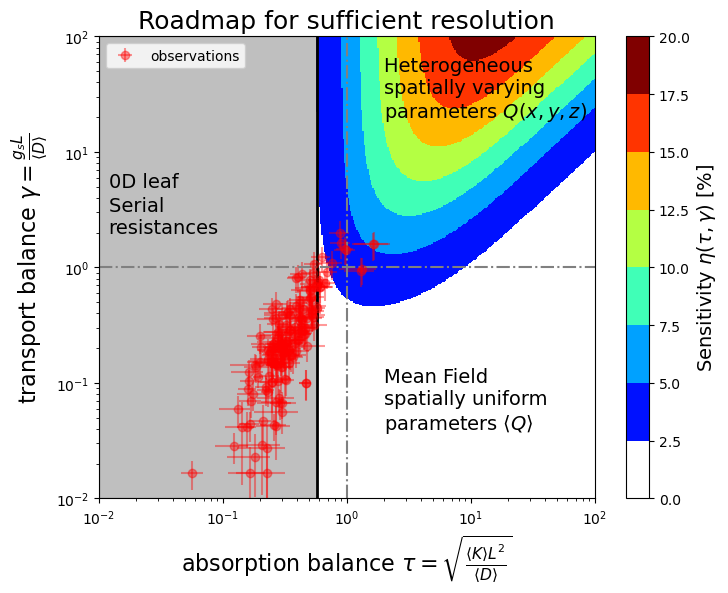

In [4]:
# search_and_save('data/', header='delta_min=0.2, kappa_min=0.2, lambda_min=0.2, zeta_compensation=0.15, N=400, n=5', N=400, n=5)


taus, gammas, sensitivities, discrepancies = fetch_data('data/')
my_plot(taus, gammas, 100*sensitivities, bounds=(0, 20, 9), save=False, figname='sensitivity', save_format='.svg')
#my_plot(taus, gammas, discrepancies, bounds=(0, 0.1, 21), title=r'Discrepancy $||\zeta - \zeta_{MF}||$', save=True, figname='discrepancy', save_format='.svg')


### Generate a histogram of the $A_N$ distribution illustrating how $\eta$ is chosen

MF solution has draw-down of 0.450
The mean draw-down is 0.436 with a standard deviation of 0.041


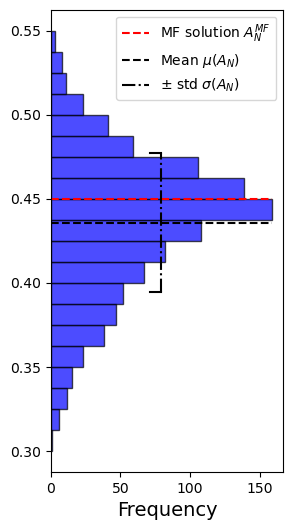

In [5]:

tau, gamma, zeta_ = 10, 10, 0.10
n = 10
delta_min, kappa_min, lambda_min = 0.2, 0.2, 0.2

leaf = lhm.Leaf(tau, gamma, zeta_, rho=(1,1,0.5), resolution=100)
domain, mf_solution = leaf.calculate_steady_state_solution()
mf_dd = 1 - mf_solution[0]
print(f"MF solution has draw-down of {mf_dd:.3f}") 

rho_deltas  = np.linspace(delta_min, 1, n)
rho_kappas  = np.linspace(kappa_min, 1, n)
rho_lambdas = np.linspace(lambda_min, 1-lambda_min, n)

drawdown = np.zeros(n**3)
index = 0
for k in range(n):
    for l in range(n):
        for m in range(n):
            rho = (rho_deltas[k], rho_kappas[l], rho_lambdas[m])
            leaf.rho = rho
            domain, solution = leaf.calculate_steady_state_solution()
            drawdown[index] = 1 - solution[0]
            index += 1

mean = np.mean(drawdown)
std = np.std(drawdown)

print(f"The mean draw-down is {mean:.3f} with a standard deviation of {std:.3f}")

fig, ax = plt.subplots(figsize=(3,6))

bins = 20
xmax, xmin = 0.55, 0.3
counts = ax.hist(drawdown, bins=bins, range=(xmin, xmax), orientation='horizontal', align='mid', color='blue', alpha=0.7, edgecolor='black')
height = np.max(counts[0])
ax.plot([0, height], [mf_dd, mf_dd], 'r--', label=r'MF solution $A_N^{MF}$')
ax.plot([0, height], [mean, mean], 'k--', label=r'Mean $\mu(A_N)$')
ax.plot([height/2, height/2], [mean-std, mean+std], 'k-.', label=r'$\pm$ std $\sigma(A_N)$')
ax.plot([height/2, height/2*0.9], [mean-std, mean-std], 'k-')
ax.plot([height/2, height/2*0.9], [mean+std, mean+std], 'k-')
# ax.text(height/3, xmin*1.1, r"$\Pi(\tau, \gamma) \equiv XX$", fontsize=14)
ax.set_xlabel('Frequency', fontsize=14)
# ax.set_ylabel('Draw-down', fontsize=14)
ax.legend()
plt.savefig('figs/drawdown_distribution.svg')
plt.show()


### Generate a 3-col figure of varying different structural parameters $\rho$

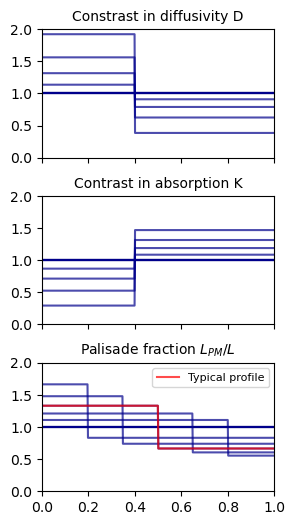

In [6]:

def kappa_delta(rho_delta, rho_kappa, rho_lambda, resolution=500):
    domain = np.linspace(0, 1, resolution)
    deltas = np.zeros(resolution)
    kappas = np.zeros(resolution)
    # finding percentage volumes occupied by the different comparments
    boundary = int(resolution*(1-rho_lambda))
    # calculate dimensionless scalars
    delta_sm = 1/((1-rho_lambda) + rho_lambda*rho_delta)
    delta_pm = rho_delta*delta_sm
    #
    kappa_pm = 1/((1-rho_lambda)*rho_kappa + rho_lambda)
    kappa_sm = rho_kappa*kappa_pm
    # fill in arrays
    deltas[:boundary] = delta_sm
    deltas[boundary:] = delta_pm
    #
    kappas[:boundary] = kappa_sm 
    kappas[boundary:] = kappa_pm
    return domain, deltas, kappas
    


fig, axs = plt.subplots(3, 1, figsize=(3,6), sharex=True, sharey=True)
axs = axs.flatten()
lines = 5

# THESE CHOICES ARE CONSISTENT WITH THE SENSITIVITY SEARCH AND An HISTOGRAM
vary_delta = np.ones((lines, 3))
vary_delta[:,0] = np.linspace(0.2, 1, lines)
vary_delta[:,2] = 0.6

vary_kappa = np.ones((lines, 3))
vary_kappa[:,1] = np.linspace(0.2, 1, lines)
vary_kappa[:,2] = 0.6

vary_lambda = np.ones((lines, 3))
vary_lambda[:,0] = 0.5
vary_lambda[:,1] = 1
vary_lambda[:,2] = np.linspace(0.2, 0.8, lines)

variations = [vary_delta, vary_kappa, vary_lambda]
titles = [r'Constrast in diffusivity D', r'Contrast in absorption K', r'Palisade fraction $L_{PM}/L$']
color = 'darkblue'

for ax, variation, title in zip(axs, variations, titles):
    for rho in variation:
        domain, deltas, kappas = kappa_delta(*rho)
        ax.plot(domain, deltas, color=color, alpha=0.7)
        ax.plot(domain, kappas, color=color, alpha=0.7)
    ax.set_title(title, fontsize=10)

domain, deltas, kappas = kappa_delta(0.5, 0.6, 0.5)
axs[2].plot(domain, deltas, color='red', alpha=0.7, label=r'Typical profile')
axs[2].legend(fontsize=8)

plt.subplots_adjust(hspace=0.3)
plt.xlim(0, 1)
plt.ylim(0, 2)
plt.savefig('figs/contrast_profiles.svg')

plt.show()
